In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from d2l import torch as d2l
from math import ceil, floor
from torch import nn

In [17]:
def get_cmap(n, name='hsv'):
    return plt.cm.get_cmap(name, n)

In [2]:
data = pd.read_csv('../data/Phuket.csv')

In [3]:
times = data['time'].to_numpy()

In [4]:
events = np.zeros(int(ceil(np.max(times))))
for i in range(0, len(times)):
    index = int(floor(times[i]))
    events[index] = events[index] + 1

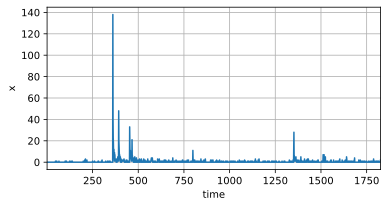

In [5]:
T = len(events)
time = torch.arange(1, T + 1, dtype=torch.float32)
x = torch.from_numpy(events.astype(np.float32))
d2l.plot(time, [x], 'time', 'x', xlim=[1, T], figsize=(6, 3))

In [6]:
tau = 100
features = torch.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i: T - tau + i]
labels = x[tau:].reshape((-1, 1))
batch_size, n_train = 16, 1200
train_iter = d2l.load_array((features[:n_train], labels[:n_train]), batch_size, is_train=True)

In [7]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

def get_net():
    net = nn.Sequential(nn.Linear(100, 10),
                        nn.ReLU(),
                        nn.Linear(10, 1))
    net.apply(init_weights)
    return net

loss = nn.MSELoss(reduction='none')

In [8]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.sum().backward()
            trainer.step()
        print(f'epoch {epoch + 1}, '
              f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}')

net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1, loss: 22.150656
epoch 2, loss: 19.827897
epoch 3, loss: 18.899733
epoch 4, loss: 18.606008
epoch 5, loss: 18.664149


In [9]:
onestep_preds = net(features)

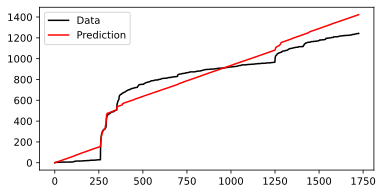

In [10]:
plt.plot(np.cumsum(events[tau:]), 'k', label='Data')
plt.plot(np.cumsum(onestep_preds.detach().numpy()), 'r', label='Prediction')
plt.legend()

In [11]:
multistep_preds = torch.zeros(T)
multistep_preds[: n_train + tau] = x[: n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(multistep_preds[i - tau:i].reshape((1, -1)))

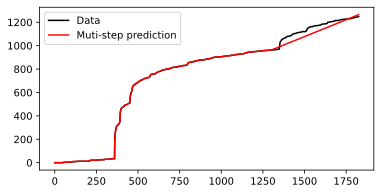

In [12]:
plt.plot(np.cumsum(events), 'k', label='Data')
plt.plot(np.cumsum(multistep_preds.detach().numpy()), 'r', label='Muti-step prediction')
plt.legend()

In [15]:
steps = [1, 4, 16, 64]
predictions = torch.zeros((T, len(steps)))
for count, step in enumerate(steps):
    for i in range(tau, T - step):
        multistep_preds = torch.zeros(T)
        multistep_preds[: i] = x[: i]
        for j in range(i, i + step):
            multistep_preds[j] = net(multistep_preds[j - tau:j].reshape((1, -1)))
        predictions[i, count] = multistep_preds[i + step - 1]

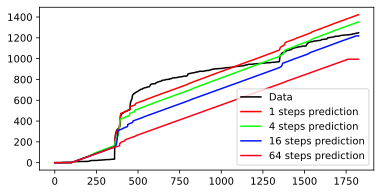

In [20]:
cmap = get_cmap(len(steps))
plt.plot(np.cumsum(events), 'k', label='Data')
for count, step in enumerate(steps):
    plt.plot(np.cumsum(predictions[:, count].detach().numpy()), color=cmap(count), label=str(step) + ' steps prediction')
plt.legend()

In [ ]:
predictions[:, 1]